# Dataset Loading and Model Training

https://www.kaggle.com/datasets/imtkaggleteam/eye-tracking-autism

In [12]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump
import numpy as np

# Load metadata
metadata_path = '/Users/ayesharahman1/Desktop/larks/backend/app/AutismDetector/EyeTrackingData/Metadata_Participants.csv'
metadata = pd.read_csv(metadata_path)

# Load eye-tracking data from all CSV files
eye_tracking_data = []
for i in range(1, 26):  # Assuming you have 25 participants
    file_name = f'/Users/ayesharahman1/Desktop/larks/backend/app/AutismDetector/EyeTrackingData/Eye-tracking Output/{i}.csv'
    temp_df = pd.read_csv(file_name, low_memory=False)
    eye_tracking_data.append(temp_df)

# Concatenate all dataframes into a single dataframe
eye_tracking_data = pd.concat(eye_tracking_data, ignore_index=True)

# Convert 'Participant' in eye-tracking data to the same type as 'ParticipantID' in metadata
eye_tracking_data['Participant'] = eye_tracking_data['Participant'].astype(str)
metadata['ParticipantID'] = metadata['ParticipantID'].astype(str)

# Merge the eye-tracking data with the metadata
data = pd.merge(eye_tracking_data, metadata, how='left', left_on='Participant', right_on='ParticipantID')

# Convert columns to numeric and coerce errors
cols_to_numeric = ['Pupil Diameter Right [mm]', 'Pupil Diameter Left [mm]']
data[cols_to_numeric] = data[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Impute missing values for numeric features
data[cols_to_numeric] = data[cols_to_numeric].fillna(data[cols_to_numeric].mean())

# Feature Engineering
data['MeanPupilDiameter'] = data[cols_to_numeric].mean(axis=1)
data['StdPupilDiameter'] = data[cols_to_numeric].std(axis=1)
data['DiffPupilDiameter'] = abs(data['Pupil Diameter Right [mm]'] - data['Pupil Diameter Left [mm]'])

# Map 'Class' to binary
data['Class'] = data['Class'].map({'ASD': 1, 'TD': 0})

# Drop rows where 'Class' is missing
data = data.dropna(subset=['Class'])

# Feature selection
feature_cols = ['MeanPupilDiameter', 'StdPupilDiameter', 'DiffPupilDiameter']
X = data[feature_cols]
y = data['Class']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearch with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

# Fit GridSearch to the training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score from the grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Evaluate the best model found by GridSearch on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the final model
model_path = 'eye-tracking-model.joblib'
dump(best_model, model_path)

# Save the scaler
scaler_path = 'eye-tracking-scaler.joblib'
dump(scaler, scaler_path)

Python(61581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(61591) Malloc

### Check for Class Imbalance

In [3]:
# Check class distribution
print(y.value_counts())

Class
0.0    857767
1.0    493390
Name: count, dtype: int64


# Confusion Matrix


Confusion Matrix:
[[157498  13904]
 [ 48254  50576]]


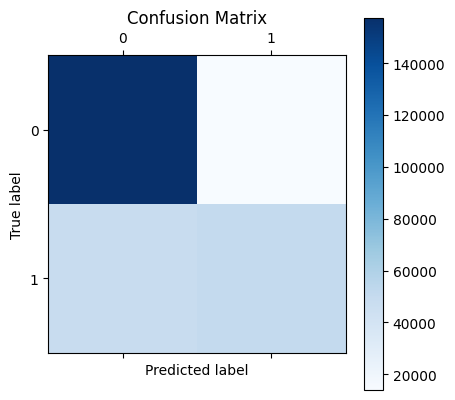

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Other metrics and Gaphs

Log loss: 0.50
AUC: 0.81


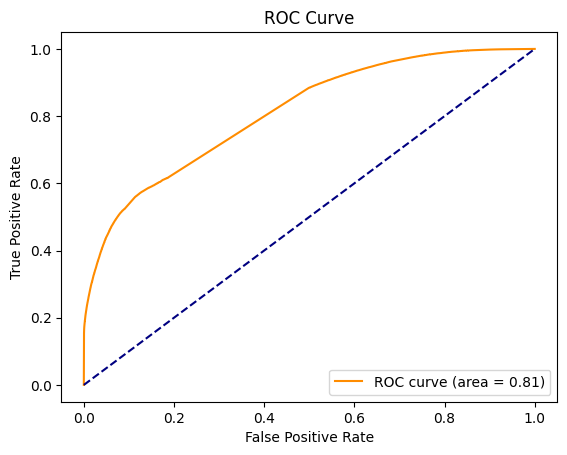

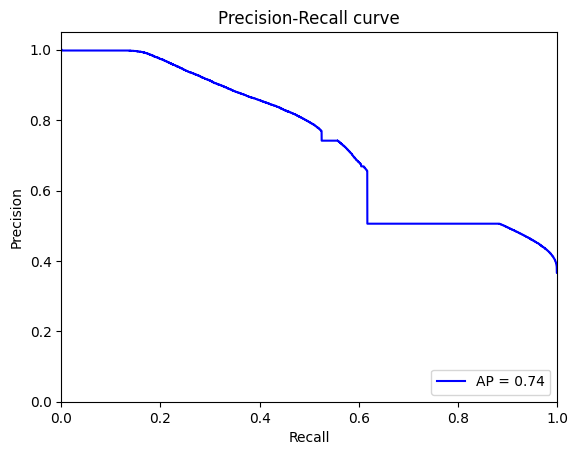

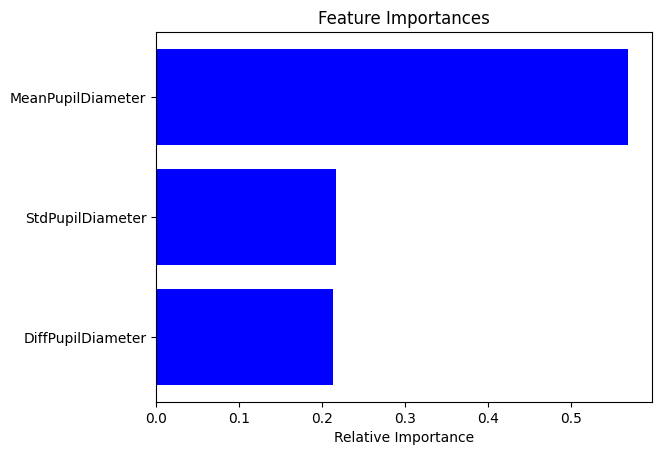

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score

# Calculate log loss
probabilities = best_model.predict_proba(X_test)
logloss = log_loss(y_test, probabilities)
print(f"Log loss: {logloss:.2f}")

# ROC Curve - calculate AUC score first to avoid naming conflicts
roc_auc_score_value = roc_auc_score(y_test, probabilities[:, 1])
print(f"AUC: {roc_auc_score_value:.2f}")

# ROC Curve - plotting
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc_value = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probabilities[:, 1])
average_precision = average_precision_score(y_test, probabilities[:, 1])
plt.figure()
plt.step(recall, precision, where='post', color='b', label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
plt.figure()
importances = best_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

